<a href="https://colab.research.google.com/github/samuramirez/cellmigration/blob/master/segmentation_1_class_cell_indiv_tiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Segmentation one class (cell)

##Mount Google Drive, install load packages

### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True);

Mounted at /content/gdrive


In [ ]:
# from google.colab import auth
# #This allows SDK to see and edit Google Drive files
# #SDK is required to interact with GCP
# auth.authenticate_user()

### Installing and loading packages 

In [2]:
#!nvidia-smi

In [3]:
import pandas as pd
#pip install --upgrade pandas

In [4]:
pd.__version__

'1.3.5'

In [5]:
pip install torch==1.7.1 torchvision==0.8.2

     |████████████████████████████████| 776.8 MB 9.9 kB/s 
     |████████████████████████████████| 12.8 MB 37.1 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.


In [6]:
import torch
import torchvision
print(torch.__version__)


1.7.1


In [7]:
print(torch.version.cuda)

10.2


In [8]:
torch.cuda.is_available()

False

In [9]:
#torch.cuda.get_device_name(0)

In [10]:
#!pip install -q torch==1.7.0 torchvision

In [11]:
#!pip install fastai==2.0.13 --no-deps


In [12]:
#!pip install fastcore==1.0.13
!pip install fastcore

     |████████████████████████████████| 56 kB 1.8 MB/s 


In [13]:
import fastcore


In [14]:
#!pip install -Uqq fastbook

In [15]:
!pip install fastai --upgrade

     |████████████████████████████████| 189 kB 2.6 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [16]:
import fastai
fastai.__version__

'2.5.3'

In [17]:
#import fastbook
#fastbook.setup_book()

In [18]:
print(fastcore.__version__)


1.3.27


In [19]:
from fastai.vision.all import *

In [20]:
import imageio
from skimage.io import imread, imsave, imshow
from skimage.exposure import rescale_intensity
import os
import numpy as np
from pathlib import Path
import re
import ntpath

!ls

gdrive	sample_data


# Segmentation Parameters


##Basic Parameters
other shared settings between training and separation

In [21]:
segmentation_target = "Cell" #@param ["Nucleus", "Cell"]

#@markdown local folder is "content" when working in colab, may be different for GCP AI
local_folder='content' #@param {type:"string"}

#@markdown directory where models are stored in and will be exported to
modelsfolder = '/content/gdrive/Othercomputers/My PC/segmentation_iteration_testing/models/fastai' #@param {type:"string"}

#@markdown local directory where preprocessed images and masks are stored for training
local_dir='local_copy' #@param {type:"string"}
!mkdir {local_dir}

## Image Preparation
shared settings between training and segmentation image/mask processing

In [22]:
#@markdown Number of slices (columns/rows) to divide input images into; for the math, pleast check https://www.desmos.com/calculator/t3cyflvlef
x_slices = 5 #@param {type:"integer"}
y_slices =  5 #@param {type:"integer"}
#@markdown dx, dy are the extra context around the segmented center in both directions
dx =  42#@param {type:"integer"}
dy =  32#@param {type:"integer"}
#@markdown x and y crop are how much to straight remove from the image to make the sizes able to be subdivided nicely
x_crop = 0 #@param {type:"integer"}
y_crop = 0 #@param {type:"integer"}

context_bounds = [dy,dx]*2 #assuming x and y symmetrical, not always true -- fix?
crop = [y_crop,x_crop]*2 #both of these are negative y, negative x, positive y, positive x

## Training-Specific Settings
parameters and paths only for training

In [23]:
#@markdown whether to fetch images from a zip file or a folder
imagezip = False #@param {type:"boolean"}

#@markdown location - zip file or folder - where input images are stored
training_images="/content/gdrive/Othercomputers/My PC/segmentation_iteration_testing/processing/training_images" #@param {type:"string"}
#@markdown input folder where masks are stored (will not be edited)
training_masks="/content/gdrive/Othercomputers/My PC/segmentation_iteration_testing/processing/training_masks" #@param {type:"string"}

# local_image_dir = local_dir + '/images';
# local_mask_dir = local_dir + '/masks';
# !mkdir {local_image_dir}
# !mkdir {local_mask_dir}

#@markdown base model that will be used to train from
inmodelname = 'seg_cell_062719_s_1_2_110619_bleb.pkl' #@param {type:"string"}
#@markdown where the model will be exported to after training
outmodelname = 'iter1_7_context_nogcp.pkl' #@param {type:"string"}



## Segmentation-Specific Settings
parameters and paths only for segmenting an experiment


In [24]:
#@markdown zip file with a big zip
segmentation_images_zip ="/content/gdrive/Othercomputers/My PC/segmentation_iteration_testing/processing/segmentation_images.zip" #@param{type:"string"}
#@markdown Path of the folder containing the movies in GCP bucket
segmentation_images="/content/gdrive/Othercomputers/My PC/segmentation_iteration_testing/processing/segmentation_images"  #@param {type:"string"}
#@markdown name of the model used to segment
segment_model_name="iter1_6_context_4_continue.pkl" #@param {type:"string"}
#@markdown path of the folder on GCP bucket where the masks will be deposited as a .zip file
segmentation_output_masks='/content/gdrive/Othercomputers/My PC/segmentation_iteration_testing/processing/segmentation_output_masks' #@param {type:"string"}

# local_segmentation_input_dir = local_dir + "/input_images"
# local_segmentation_output_dir = local_dir + "/output_masks"
# !mkdir {local_segmentation_input_dir}
# !mkdir {local_segmentation_output_dir}

# Preparing data to train only on cell (from combined nuc-memb masks)

###Prepare fast.ai data loader

In [ ]:
path=Path("/"+local_folder)

In [ ]:
path2 = untar_data(URLs.CAMVID_TINY)

In [ ]:
def label_func(x): return training_masks + '/' + f'{x.stem}.TIF'

In [ ]:
codes = np.loadtxt(path2/'codes.txt', dtype=str)

In [ ]:
trainingset = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   #batch_tfms=aug_transforms(size=(512,672)))
                   batch_tfms=aug_transforms(size=(256,336)))

In [ ]:
dls = trainingset.dataloaders(training_images, path=path, bs=8);
print(os.listdir(training_images));
dls.dataset
dls.n_inp

['migration1_s6_t15-12.TIF', 'random2_s11_t3-2.TIF', 'migration1_s3_t11-20.TIF', 'random_s3_t216-17.TIF', 'migration1_s1_t5-1.TIF', 'migration1_s4_t48-0.TIF', 'random_s16_t236-6.TIF', 'random_s15_t2-0.TIF', 'migration1_s5_t29-11.TIF', 'migration1_s10_t6-13.TIF', 'migration1_s11_t49-21.TIF', 'random_s8_t51-13.TIF', 'migration1_s14_t5-11.TIF', 'random_s15_t98-3.TIF', 'migration1_s1_t5-24.TIF', 'random_s5_t135-17.TIF', 'random_s11_t57-4.TIF', 'random2_s8_t11-20.TIF', 'random2_s9_t69-5.TIF', 'migration1_s5_t29-17.TIF', 'random_s7_t76-0.TIF', 'random_s16_t91-22.TIF', 'random2_s9_t110-18.TIF', 'migration1_s7_t7-5.TIF', 'random_s11_t57-7.TIF', 'random_s6_t110-11.TIF', 'random_s3_t104-8.TIF', 'random_s6_t220-8.TIF', 'random2_s11_t219-16.TIF', 'random2_s9_t35-8.TIF', 'random2_s11_t174-23.TIF', 'random_s4_t63-8.TIF', 'random2_s2_t38-13.TIF', 'migration1_s13_t1-20.TIF', 'migration1_s9_t6-23.TIF', 'random_s3_t216-21.TIF', 'migration1_s4_t48-4.TIF', 'random2_s9_t35-0.TIF', 'migration1_s4_t48-2.TIF'

1

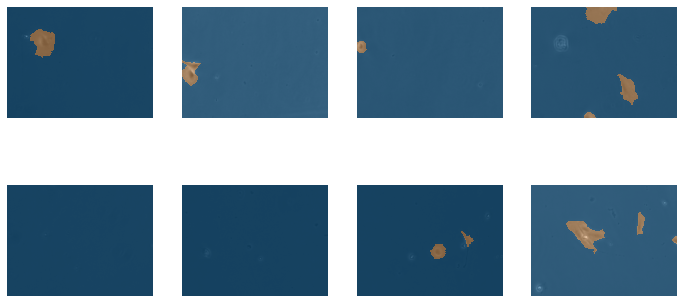

In [ ]:
dls.show_batch(max_n=10)

#Training

In [ ]:
#learn = unet_learner(dls, resnet34)
loadedlearner=load_learner(modelsfolder + '/' + inmodelname,cpu=True)
loadedlearner.dls=dls

In [ ]:
#learn.fine_tune(8)
loadedlearner.fine_tune(5)


epoch,train_loss,valid_loss,time


KeyboardInterrupt: ignored

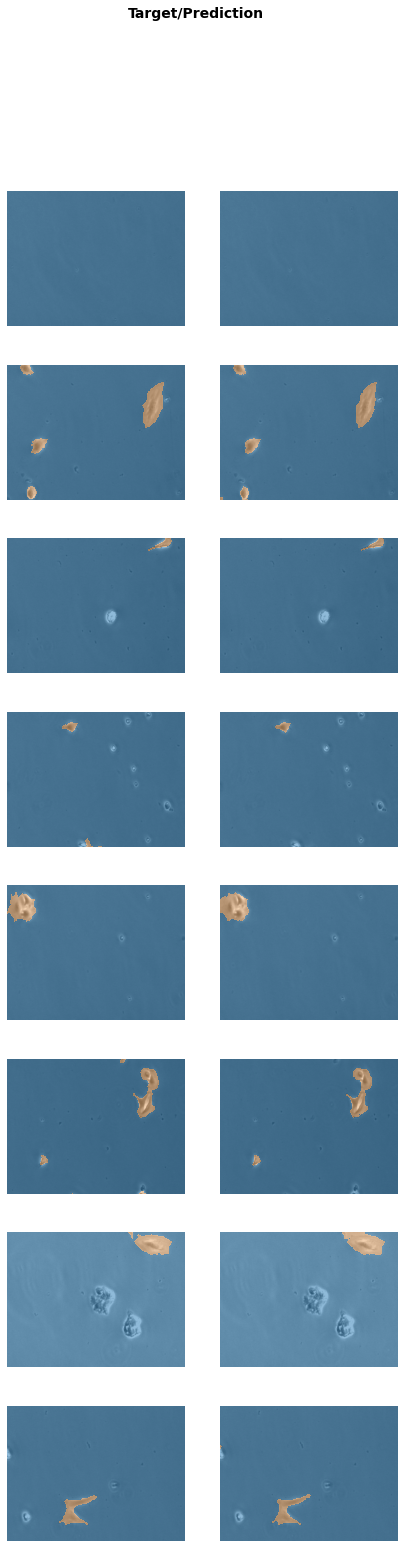

In [ ]:
n = 16
loadedlearner.show_results(max_n=n, figsize=(7,25))

In [ ]:
loadedlearner.export(fname=modelsfolder + '/' + outmodelname, pickle_protocol=2)

#Segment experiment

### Loading a trained model

In [33]:
!zip -FF '{segmentation_images_zip}' -O test.zip
!unzip -u test.zip -d '{segmentation_images}'

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/Othercomputers/My PC/segmentation_iteration_testing/processing/segmentation_images/segmentation_images/p1_s9_t136-17.TIF  
  inflating: /content/gdrive/Othercomputers/My PC/segmentation_iteration_testing/processing/segmentation_images/segmentation_images/p1_s9_t136-18.TIF  
  inflating: /content/gdrive/Othercomputers/My PC/segmentation_iteration_testing/processing/segmentation_images/segmentation_images/p1_s9_t136-19.TIF  
  inflating: /content/gdrive/Othercomputers/My PC/segmentation_iteration_testing/processing/segmentation_images/segmentation_images/p1_s9_t136-2.TIF  
  inflating: /content/gdrive/Othercomputers/My PC/segmentation_iteration_testing/processing/segmentation_images/segmentation_images/p1_s9_t136-20.TIF  
  inflating: /content/gdrive/Othercomputers/My PC/segmentation_iteration_testing/processing/segmentation_images/segmentation_images/p1_s9_t136-21.TIF  
  inflating: /content/gdrive/Othercomp

In [34]:
print("available cpu count:",len(os.sched_getaffinity(0)));

available cpu count: 2


In [35]:
def label_func(x): return None; ##dummy function to make unpickling work, never used
loadedlearner=load_learner(modelsfolder + '/' + segment_model_name,cpu=True);
if torch.cuda.is_available():
  print("using gpu");
  loadedlearner.model = loadedlearner.model.cuda();


In [36]:
## prepare files

#as far as I can tell through testing, this only matters for ensuring RAM usage stays low
batchSize = 64; 

files = get_image_files(segmentation_images+"/segmentation_images");
completed_masks = os.listdir(segmentation_output_masks);
print(len(completed_masks))
print(len(files))
# print(completed_masks[0]);
# print(files[0])
files = [f for f in files if os.path.basename(f) not in completed_masks];
print(len(files))

fileChunks = chunked(files, chunk_sz=batchSize);


0
82025
82025


In [ ]:
for chunk in progress_bar(fileChunks,len(files)//batchSize):
  # print('processing batch...');
  dl = loadedlearner.dls.test_dl(chunk,num_workers=len(os.sched_getaffinity(0)),device='cuda');
  if torch.cuda.is_available():
    print("cuda available")
    dl.to('cuda');
  _,_,dec_preds = loadedlearner.get_preds(with_decoded=True,dl=dl);
  for path,prediction in zip(chunk,dec_preds):
    basename = os.path.basename(path);
    # print(prediction.shape);
    imsave(segmentation_output_masks+'/'+basename,prediction.numpy().astype('uint8'),check_contrast=False);
with open(segmentation_output_masks/'segmentation_complete.flag','w') as f:
  pass;